Link demo: https://share.streamlit.io/thanhtruong1712/fake-news-detection/streamlit.py

Tiến độ hoàn thành của Project : 100%

## Danh sách thành viên trong nhóm
| MSSV        | Họ và tên          | 
| ----------- | -----------------  | 
| 1712722     | Trần Đình Sang     |
| 1712770     | Trương Thị Lệ Thanh|
| 1712771     | Bùi Thái Tấn Thành | 
| 1712778     | Thống A Thảo       |        

## Bảng phân công công việc
| Công việc | Thành viên phụ trách | Mức độ hoàn thành | 
| --------| -----------------  | ---------------------|
| Tiền xử lý văn bản tiếng Việt | Thanh & Thành | 100% |
| EDA (khám phá dữ liệu) | Sang & Thảo | 0% |
| Mô hình hóa | Thanh & Thành | 100% |
| Deploy mô hình | Sang & Thảo | 0% |


# I. Dữ liệu

## Thông tin dữ liệu

#### Nguồn dữ liệu: VNFD Dataset

- Tập dữ liệu 223 record bản tin tiếng Việt, gồm 2 nhãn: 1 (tin giả) và 0 (tin thật)

# II. Import các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import sklearn
import pickle
import tensorflow
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
# from nltk.stem.wordnet import WordNetLemmatizer
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import plot_confusion_matrix,roc_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

2022-01-06 23:58:32.566929: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-06 23:58:32.567008: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/thanhtruong/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/thanhtruong/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/thanhtruong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# III. Khám phá dữ liệu

### Đọc dữ liệu từ file csv vào dataframe

In [26]:
df = pd.read_csv('vn_news_223_tdlfr.csv')
# df.head()
df.text[4]

'Đại học Hutech sẽ áp dụng cải cách "Tiếq Việt" vào năm học 2018?\nMới đây, ông Phạm Ngọc Thanh, Phó giám đốc Sở GD – ĐT Tp. Hồ Chí Minh chuyên trách về Hệ giáo dục Đại học tại thành phố đã lên tiếng về vấn đề cải cách tiếng Tiếng Việt của PGS.TS Bùi Hiền.\nÔng cho biết TP.HCM đặc biệt quan tâm đến đề xuất của PGS và rất sẵn lòng thí điểm vào giảng dạy tại các trường Đại học trên địa bàn TP.HCM.\nÔng Phạm Ngọc Thanh, Phó Giám đốc Sở GDĐT TP.HCM.\nPhó giám đốc Sở GDĐT TP.HCM Phạm Ngọc Thanh chia sẻ rằng TP.HCM là thành phố phát triển với số lượng người nước ngoài cư trú, làm việc và học tập nhiều nhất cả nước. Rất nhiều người trong số đó mong muốn được học Tiếng Việt để giúp ích cho việc sinh sống và làm việc tại Việt Nam một cách thuận tiện hơn. Tuy nhiên, với cấu trúc ngữ pháp cũng như cách phát âm phức tạp của bộ chữ hiện tại thì khá khó khăn để người nước ngoài có thể học tập.\nSau khi xem xét và tìm hiểu toàn bộ nghiên cứu và đề xuất cải tiến bảng chữ cái Tiếng Việt của PGS.TS Bùi 

### Dữ liệu gồm có bao nhiêu dòng và bao nhiêu cột?

In [3]:
rows, collumns = df.shape
print("Dữ liệu có {} dòng và {} cột".format(rows, collumns))

Dữ liệu có 223 dòng và 3 cột


## 1.  Tiền xử lý văn bản tiếng Việt

### Các bước tiền xử lý văn bản cơ bản gồm: 
- Lowercase
- Loại stopwords
- Tokenizer
- Stemming
- Loại noise
- Loại dấu câu

#### Đọc dữ liệu stopwords từ file txt

In [4]:
def get_stopword_list(filename):
    with open(filename,'r',encoding='utf-8') as f:
        stopwords=f.readlines()
        stopset=set(m.strip() for m in stopwords)
        return list(frozenset(stopset))
stopwords=set(get_stopword_list('vietnamese.txt'))

In [5]:
regex = re.compile('[%s]' % re.escape(string.punctuation))
wordnet = WordNetLemmatizer()

#### Hàm tiền xử lý văn bản tiếng Việt

In [6]:
def preprocessing_basic(text):
    text = re.sub(r'http\S+','', text)  #Loại noise(xóa link)
    text = re.sub("\\W", ' ', text)     # Xóa khoảng trắng thừa
    #Loại tokenizer và dấu câu
    token_doc = word_tokenize(text)
    result_token = []
    for i in token_doc:
        new_token = regex.sub(u'',i)
        if not new_token == u'':
            result_token.append(new_token)
    #Loại stopwords
    result_stopwords = []
    for text in result_token:
        tmp = text.split(' ')
        for i in tmp:
            if not i in stopwords :
                result_stopwords.append(i)
    #Xử lý stemming và lemmatizion
    final_doc = []
    for i in result_stopwords:
        final_doc.append(wordnet.lemmatize(i))
    return ' '.join(final_doc).lower()

In [7]:
tqdm.pandas()
df.text = df.text.progress_map(preprocessing_basic)
#df.text[2]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 223/223 [00:04<00:00, 54.56it/s]


## 2. EDA (Khám phá dữ liệu)

#### Thông tin dữ liệu:

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    223 non-null    object
 1   domain  223 non-null    object
 2   label   223 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 5.4+ KB


Ta thấy dữ liệu không bị thiếu, kiểu dữ liệu không sai

#### Kiểm tra các dòng có bị lặp không?

In [9]:
print('Số dòng dữ liệu bị lặp: ',df.index.duplicated().sum())

Số dòng dữ liệu bị lặp:  0


#### Kiểm tra phân bố các class có chênh lệch không?

In [10]:
df['label'].value_counts()

0    123
1    100
Name: label, dtype: int64

#### Các thông tin thống kê của văn bản 

In [11]:
record_len = df.text.str.len()
print("Chiều dài trung bình của mỗi record: ",(record_len.sum()/len(record_len)).round(3))

Chiều dài trung bình của mỗi record:  1491.812


# IV. Mô hình hóa dữ liệu

In [12]:
#Hàm vẽ ma trận
def plot_matrix(classifier,X_test,Y_test):
    class_name=df.label.value_counts()
    np.set_printoptions(precision=2)
    titles_options=[("confusion matrix,without normalization",None),("normalized confusion matrix",None)]
    for title,normalize in titles_options:
        disp=plot_confusion_matrix(classifier,X_test,Y_test,display_labels=class_name,cmap=plt.cm.Blues,normalize=normalize)
        disp.ax_.set_title(title)
        print(title)
        print(disp.confusion_matrix)

        
def upload_classifier(classifier):
    X_train,X_test,Y_train,Y_test=train_test_split(df.text,df.label,test_size=0.25,random_state=2020)
    pipe=Pipeline([('vect',CountVectorizer()),('tfidf',TfidfTransformer()),('model',classifier)])
    model=pipe.fit(X_train,Y_train)
    prediction=model.predict(X_test)
    prob=model.predict_proba(X_test)
    plot_matrix(classifier=model,X_test=X_test,Y_test=Y_test)
    return model,prob,Y_test

def generate_roc_curve(model,Y_test,prob,title):
    pred=prob[:,1]
    fpr,tpr,threshold=roc_curve(Y_test,pred)
    roc_auc=auc(fpr,tpr)
    plt.title('{}'.format(title))
    plt.plot(fpr,tpr,'b',label='auc=%0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Logistic Regression

confusion matrix,without normalization
[[26  1]
 [10 19]]
normalized confusion matrix
[[26  1]
 [10 19]]


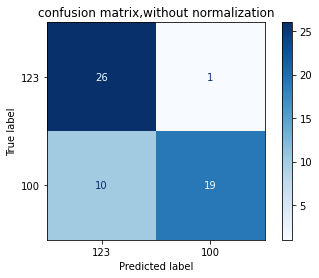

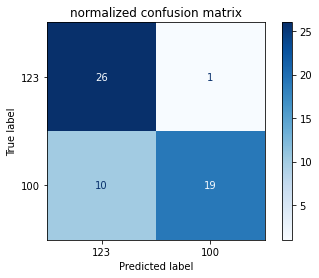

In [13]:
LR_model,prob,Y_test=upload_classifier(classifier=LogisticRegression())

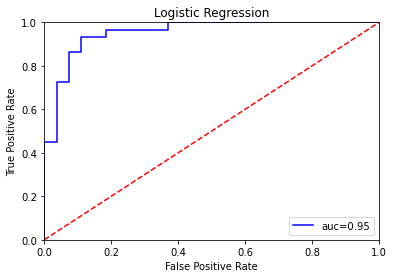

In [14]:
generate_roc_curve(model=LR_model,Y_test=Y_test,prob=prob,title='Logistic Regression')

## Gradient Boost Classifier

confusion matrix,without normalization
[[22  5]
 [11 18]]
normalized confusion matrix
[[22  5]
 [11 18]]


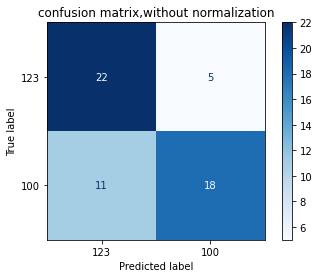

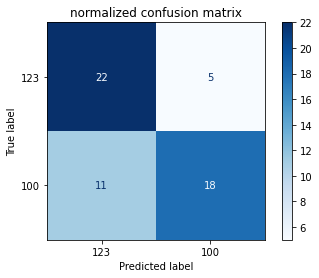

In [15]:
GBC_model,prob,Y_test=upload_classifier(classifier=GradientBoostingClassifier())

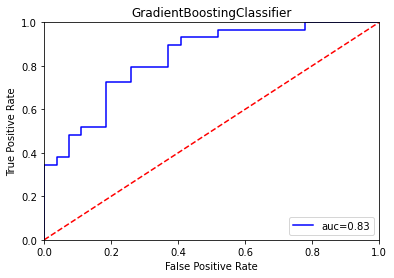

In [16]:
generate_roc_curve(model=GBC_model,Y_test=Y_test,prob=prob,title='GradientBoostingClassifier')

In [17]:
model_file_list = [r"models/LR_model.pkl",
                   r"models/GBC_model.pkl"]

model_list = [LR_model,GBC_model]

for model, filename in zip(model_list, model_file_list):
    pickle.dump(model, open(filename, 'wb'))

In [18]:
def pre_tokenizer(text, maxword):
    tokenizer = Tokenizer(num_words = maxword)
    tokenizer.fit_on_texts(text)
    with open('tokenizer.pickle','wb') as f:
        pickle.dump(tokenizer, f, protocol = pickle.HIGHEST_PROTOCOL)
pre_tokenizer(df.text, 200)